In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [3]:
client = Client(n_workers=24)
client

Client Scheduler: tcp://127.0.0.1:33401 Dashboard: /proxy/8787/status,Cluster Workers: 24 Cores: 48 Memory: 202.49 GB


In [4]:
session = cc.database.create_session()

In [5]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_IAF_cycle1',  {'expt':'01deg_jra55v140_iaf','dir':'access-om2-01'}),
    ('01deg_IAF_cycle2',  {'expt':'01deg_jra55v140_iaf_cycle2','dir':'access-om2-01'})
                        ])

## Just checking the final data for each expt.

In [6]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))
    
end_time = '2019-01-01'
print(' Setting end_time to',end_time)

01deg_jra55v13_ryf9091 goes from 1900 to 2121
01deg_jra55v140_iaf goes from 1958 to 2018
01deg_jra55v140_iaf_cycle2 goes from 1958 to 2018
 Setting end_time to 2019-01-01


## Scalar diagnostics

In [7]:
def plot_timeseries(variable,end_time):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 1min 2s, sys: 2.44 s, total: 1min 5s
Wall time: 1min 20s


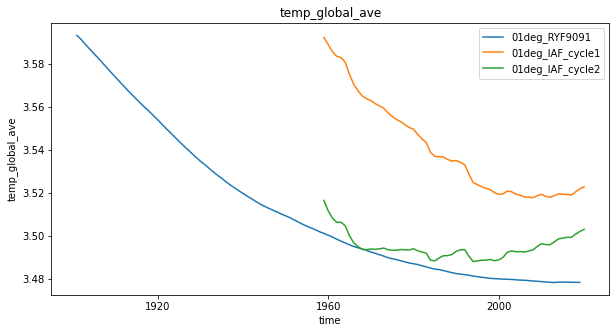

In [7]:
%%time
plot_timeseries('temp_global_ave',end_time)

### Global Average Salinity

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 1min 6s, sys: 2.47 s, total: 1min 9s
Wall time: 1min 24s


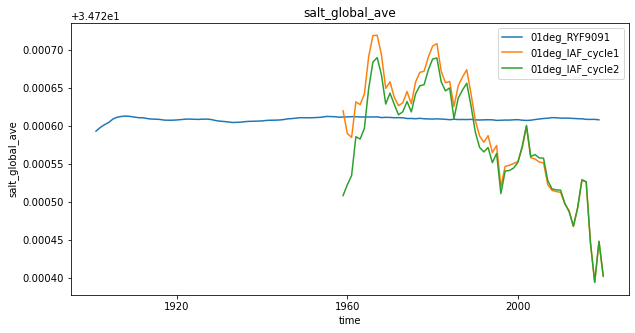

In [8]:
%%time
plot_timeseries('salt_global_ave',end_time)

### Surface Temperature

CPU times: user 1min 1s, sys: 2.36 s, total: 1min 4s
Wall time: 1min 20s


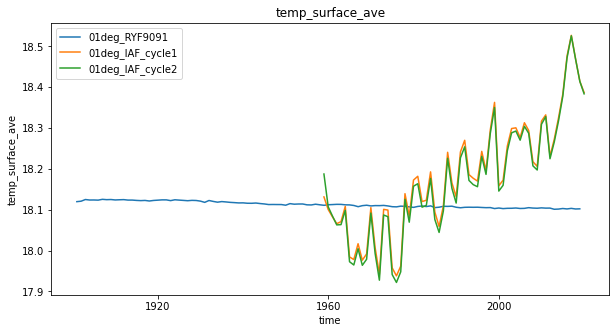

In [10]:
%%time
plot_timeseries('temp_surface_ave',end_time)

### Surface Salinity

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 1min 8s, sys: 2.23 s, total: 1min 10s
Wall time: 1min 25s


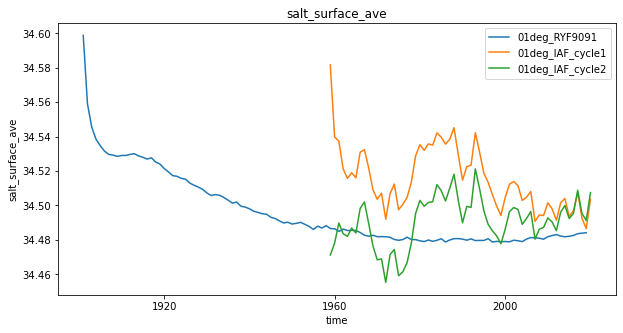

In [12]:
%%time
plot_timeseries('salt_surface_ave',end_time)

### Total Kinetic Energy

CPU times: user 1min 8s, sys: 2.06 s, total: 1min 10s
Wall time: 1min 25s


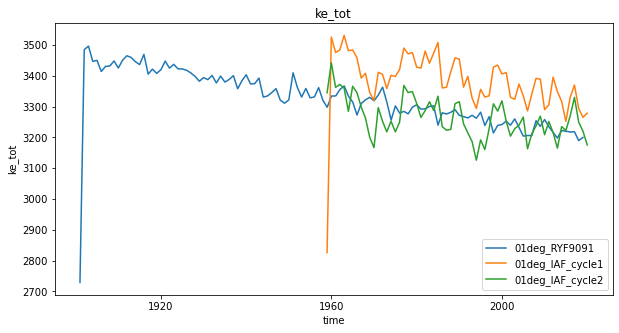

In [13]:
%%time
plot_timeseries('ke_tot',end_time)

## Area-Averaged Tracer Diagnostics

In [7]:
def plot_upper_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

In [ ]:
%%time
plot_upper_ocean('temp',end_time)

01deg_jra55v13_ryf9091


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:43748 remote=tcp://127.0.0.1:33401>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:43746 remote=tcp://127.0.0.1:33401>
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.core - ERROR - 'tcp://127.0.0.1:36995'
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/distributed/core.py", line 597, in handle_stream
    handler(**merge(extra, msg))

In [ ]:
%%time
plot_upper_ocean('salt',end_time)

### Deep Ocean Temperature/Salinity

In [ ]:
def plot_lower_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

In [ ]:
%%time
plot_lower_ocean('temp',end_time)

In [ ]:
%%time
plot_lower_ocean('salt',end_time)

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2
CPU times: user 45.2 s, sys: 2.21 s, total: 47.4 s
Wall time: 1min 17s


Text(0.5, 1.0, 'ACC Transport')

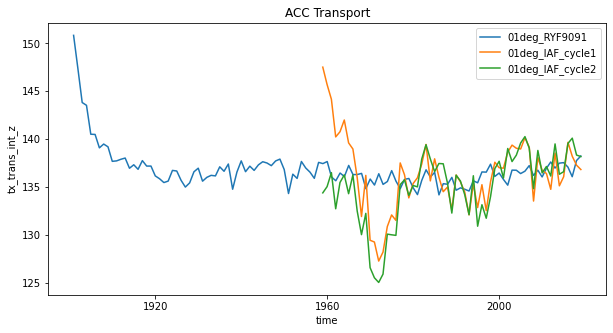

In [14]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

01deg_jra55v13_ryf9091


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2
CPU times: user 19min 2s, sys: 38.9 s, total: 19min 41s
Wall time: 22min 45s


Text(0.5, 1.0, 'AABW Cell')

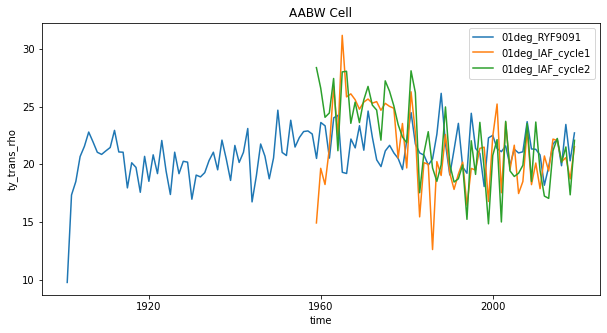

In [15]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2
CPU times: user 5min 44s, sys: 19.4 s, total: 6min 3s
Wall time: 8min 34s


Text(0.5, 1.0, 'AMOC Cell')

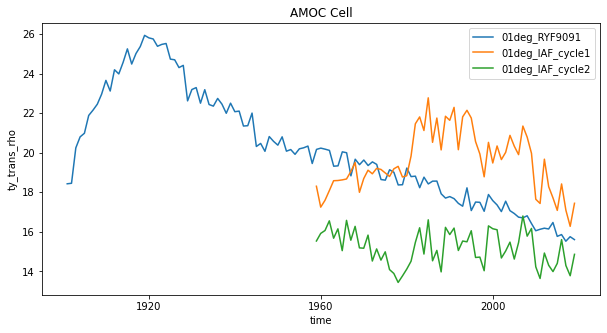

In [15]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

## Global Overturning Streamfunction

In [11]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

01deg_jra55v13_ryf9091


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44832 remote=tcp://127.0.0.1:39031>


01deg_jra55v140_iaf
01deg_jra55v140_iaf_cycle2


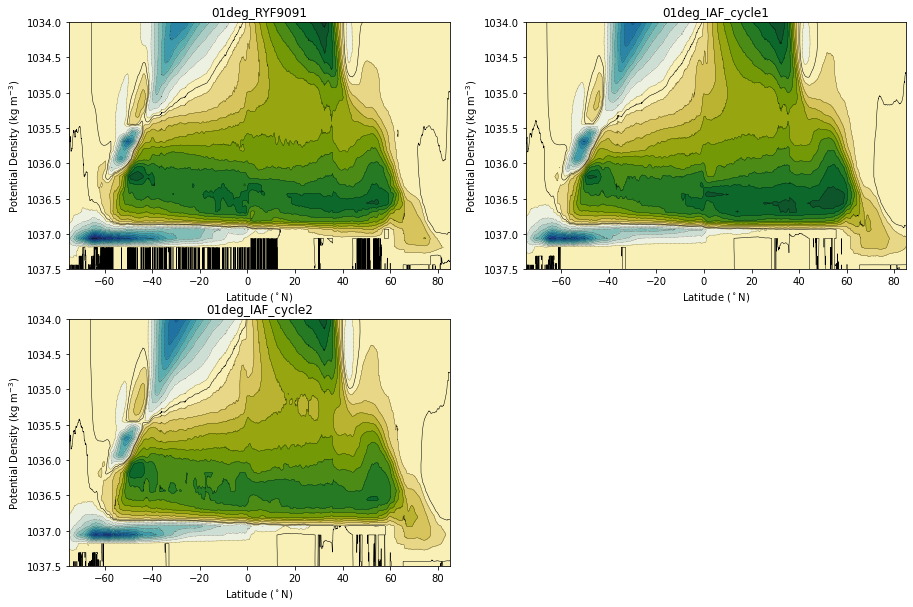

In [12]:
plt.figure(figsize=(15,10))
variable='ty_trans_rho'
ii=0
for ekey in exptdict.keys():
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,start_time='2010-01-01',end_time=end_time)
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)



### Ice Area (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

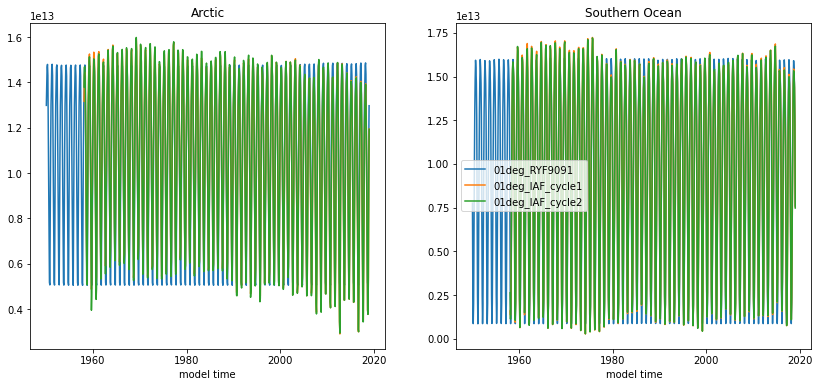

In [13]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

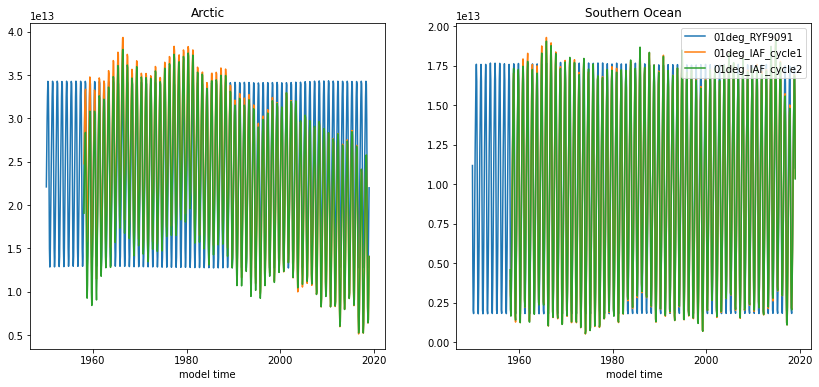

In [14]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')